    
    The following is a visualization of the counts data from the  results of the antiSMASH run Paloma had me perform on the ICL genome collection. antiSMASH searches the genome for possible biosynthetic gene clusters (BGCs). 

# Imports

In [1]:
import numpy as np
import pandas as pd

import scipy
import sklearn

import itertools as it
import os

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [2]:
pd.set_option('display.max_columns', 40)

# Data

In [3]:
path = '../data_o/antismash/'
fname = 'bgc_counts.csv'

# Re-Processing

In [4]:
# import data
df = pd.read_csv(pjoin(path,fname), na_values='-')

In [5]:
# drop columns not needed in this analysis
# drop 'Other' because this it is too ambiguous
df = df.drop(labels=['Kingdom', 'Class', 'other', 'ICL_ID', 'strain'], axis=1)

In [6]:
df.head()
# the following represents the predicted gene clusters per ICL strain in the collection

,alsphere_ID,Phylum,Order,Family,Genus,acyl_amino_acids-siderophore,arylpolyene,arylpolyene-ladderane,arylpolyene-nrps,arylpolyene-resorcinol,bacteriocin,butyrolactone,ectoine,hserlactone,ladderane,lantipeptide,lantipeptide-t1pks-nrps,lassopeptide,microviridin,nrps,otherks,phenazine,phosphonate,resorcinol,sactipeptide-head_to_tail,siderophore,siderophore-nrps,t1pks,t1pks-nrps,t1pks-otherks,t3pks,terpene,terpene-nrps,thiopeptide
0,Chlamy10,Bacteroidetes,Flavobacteriales,Flavobacteriaceae,Chryseobacterium,NaN,1.0,NaN,1.0,1.0,4.0,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,4.0,1.0,NaN
1,Chlamy10,Proteobacteria,Burkholderiales,Comamonadaceae,Variovorax,NaN,1.0,NaN,1.0,1.0,4.0,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,4.0,1.0,NaN
2,Chlamy10,Proteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NaN,1.0,NaN,1.0,1.0,4.0,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,4.0,1.0,NaN
3,Chlamy100,Proteobacteria,Burkholderiales,Burkholderiaceae,Cupriavidus,NaN,2.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
4,Chlamy102,Bacteroidetes,Flavobacteriales,Flavobacteriaceae,Chryseobacterium,NaN,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN


In [7]:
# change all NaN values to 0, this create a sparse matrix
df = df.replace(np.nan, 0.0)

In [8]:
df.columns

# save alsphere_labels for later... not sure if they can be used
# once dimensionality reduction has been done however
alsphere_labels = df['alsphere_ID']

Index(['alsphere_ID', 'Phylum', 'Order', 'Family', 'Genus',
       'acyl_amino_acids-siderophore', 'arylpolyene', 'arylpolyene-ladderane',
       'arylpolyene-nrps', 'arylpolyene-resorcinol', 'bacteriocin',
       'butyrolactone', 'ectoine', 'hserlactone', 'ladderane', 'lantipeptide',
       'lantipeptide-t1pks-nrps', 'lassopeptide', 'microviridin', 'nrps',
       'otherks', 'phenazine', 'phosphonate', 'resorcinol',
       'sactipeptide-head_to_tail', 'siderophore', 'siderophore-nrps', 't1pks',
       't1pks-nrps', 't1pks-otherks', 't3pks', 'terpene', 'terpene-nrps',
       'thiopeptide'],
      dtype='object')

In [9]:
#df.iloc[:,5:].info()

In [10]:
# combining certain columns whose names are a bit ambiguous but could belong together
# however this means that some counts are double counted in different columns
df['siderophore'] = df['acyl_amino_acids-siderophore'] + df['siderophore'] + df['siderophore-nrps']
df['nrps'] = df['nrps'] + df['siderophore-nrps'] + df['arylpolyene-nrps'] + df['t1pks-nrps']
df['ladderane'] = df['ladderane'] + df['arylpolyene-ladderane']

df['arylpolyene'] = df['arylpolyene'] + df['arylpolyene-ladderane'] + df['arylpolyene-resorcinol'] + df['arylpolyene-nrps']
df['resorcinol'] = df['resorcinol'] + df['arylpolyene-resorcinol']
df['lantipeptide'] = df['lantipeptide'] + df['lantipeptide-t1pks-nrps']

df['t1pks'] = df['t1pks'] + df['t1pks-nrps'] + df['otherks'] + df['t1pks-otherks']
df['terpene'] = df['terpene'] + df['terpene-nrps']

In [11]:
df = df.drop(labels=['siderophore-nrps', 'acyl_amino_acids-siderophore', 
                'arylpolyene-ladderane', 'arylpolyene-resorcinol',
                'lantipeptide-t1pks-nrps', 't1pks-nrps', 'otherks',
                't1pks-otherks', 'terpene-nrps', 'arylpolyene-nrps'], axis=1)

In [12]:
df = df.drop_duplicates(subset='alsphere_ID', keep='last')
df.head()

,alsphere_ID,Phylum,Order,Family,Genus,arylpolyene,bacteriocin,butyrolactone,ectoine,hserlactone,ladderane,lantipeptide,lassopeptide,microviridin,nrps,phenazine,phosphonate,resorcinol,sactipeptide-head_to_tail,siderophore,t1pks,t3pks,terpene,thiopeptide
2,Chlamy10,Proteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,3.0,4.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,11.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,5.0,0.0
3,Chlamy100,Proteobacteria,Burkholderiales,Burkholderiaceae,Cupriavidus,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0
6,Chlamy102,Proteobacteria,Xanthomonadales,Xanthomonadaceae,Stenotrophomonas,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,Chlamy103,Bacteroidetes,Flavobacteriales,Flavobacteriaceae,Chryseobacterium,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,7.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0
8,Chlamy104,Proteobacteria,Burkholderiales,Burkholderiaceae,Cupriavidus,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0


# ML Set-Up
    
    Keep only the numerical information for PCA 

In [13]:
from sklearn import preprocessing

In [14]:
features = df.iloc[:,5:].columns
X = df.loc[:,features].values

X = preprocessing.StandardScaler().fit_transform(X)

data = pd.DataFrame(data=X, columns=features)

y_order = df.loc[:,['Order']].values
y_family= df.loc[:,['Family']].values
y_genus = df.loc[:,['Genus']].values
y_phylum= df.loc[:,['Phylum']].values

In [15]:
df['Genus'].unique()
df['Order'].unique()
df['Family'].unique()
df['Phylum'].unique()

array(['Pseudomonas', 'Cupriavidus', 'Stenotrophomonas',
       'Chryseobacterium', 'Bosea', 'Arthrobacter', 'Variovorax',
       'Brevundimonas', 'Micrococcus', 'Bacillus', 'Massilia',
       'Sphingopyxis', 'Sphingomonas', 'Microbacterium', 'Aeromonas',
       'Pantoea', 'Acidovorax'], dtype=object)

array(['Pseudomonadales', 'Burkholderiales', 'Xanthomonadales',
       'Flavobacteriales', 'Rhizobiales', 'Actinomycetales',
       'Caulobacterales', 'Bacillales', 'Sphingomonadales',
       'Aeromonadales', 'Enterobacteriales'], dtype=object)

array(['Pseudomonadaceae', 'Burkholderiaceae', 'Xanthomonadaceae',
       'Flavobacteriaceae', 'Bradyrhizobiaceae', 'Micrococcaceae',
       'Comamonadaceae', 'Caulobacteraceae', 'Bacillaceae',
       'Oxalobacteraceae', 'Sphingomonadaceae', 'Microbacteriaceae',
       'Aeromonadaceae', 'Enterobacteriaceae'], dtype=object)

array(['Proteobacteria', 'Bacteroidetes', 'Actinobacteria', 'Firmicutes'],
      dtype=object)

# PCA Decomposition

In [16]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

In [17]:
pca = PCA(n_components=2)
spca = SparsePCA(n_components=2)

pcomps = pca.fit_transform(X)
pcomps_spca = spca.fit_transform(X)

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


# Scree Plot

<BarContainer object of 2 artists>

Text(0, 0.5, '% Explained Variance')

Text(0.5, 0, 'Principal Componenet')

Text(0.5, 1.0, 'Scree Plot')

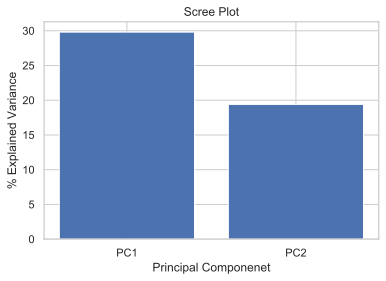

In [18]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("% Explained Variance")
plt.xlabel("Principal Componenet")
plt.title('Scree Plot')
plt.show()

# Visualize
    
    Most of the Varianace is Explained by the first 2 principal componenets

In [19]:
pcompdf = pd.DataFrame(data=pcomps[:,0:2], columns = ['pc1', 'pc2'])
pcompdf_spca = pd.DataFrame(data=pcomps_spca[:,0:2], columns = ['pc1', 'pc2'])

### Concatenation

In [20]:
## Explore PCA by Genus, Family, and Order
mdfg = pd.concat(objs=[pcompdf, df['Genus']], axis=1)

mdff = pd.concat(objs=[pcompdf, df['Family']], axis=1)

mdfo = pd.concat(objs=[pcompdf, df['Order']], axis=1)

mdfp = pd.concat(objs=[pcompdf, df['Phylum']], axis=1)



In [21]:
%config InteractiveShell.ast_node_interactivity='none'

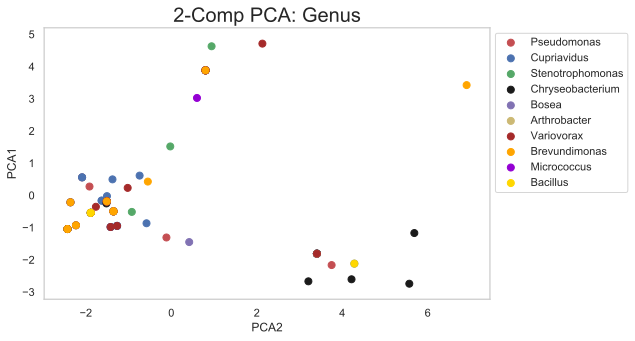

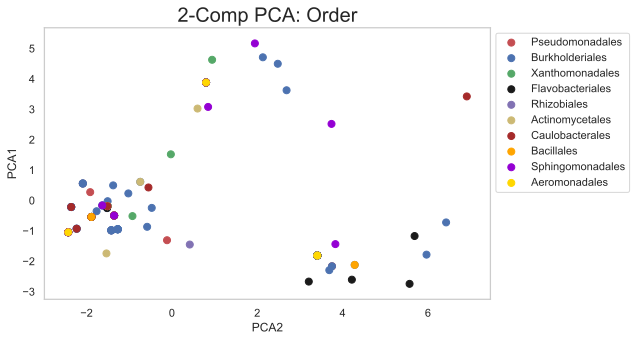

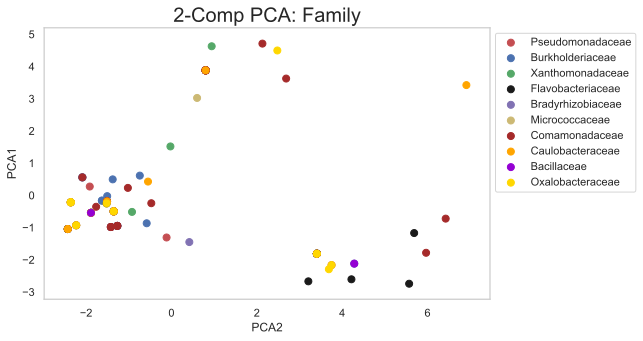

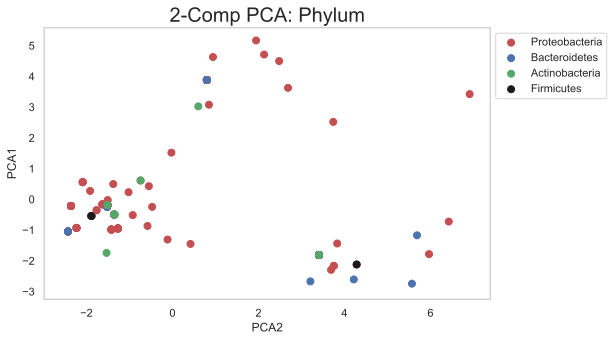

In [23]:
fs = (8,5)

############
## GENUS ###
############

targs = df['Genus'].unique()
fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Genus", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfg['Genus'] == targ
    ax.scatter(mdfg.loc[idxkeep, "pc1"],
               mdfg.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs, bbox_to_anchor=(1,1))
ax.grid()



############
## ORDER ###
############

targs = df['Order'].unique()
fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Order", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfo['Order'] == targ
    ax.scatter(mdfo.loc[idxkeep, "pc1"],
               mdfo.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()


############
###FAMILY###
############

targs = df['Family'].unique()

fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Family", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdff['Family'] == targ
    ax.scatter(mdff.loc[idxkeep, "pc1"],
               mdff.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()



############
###PHYLUM###
############


targs = df['Phylum'].unique()

fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Phylum", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfp['Phylum'] == targ
    ax.scatter(mdfp.loc[idxkeep, "pc1"],
               mdfp.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()

# SparsePCA

In [ ]:
## Explore PCA by Genus, Family, and Order
mdfg = pd.concat(objs=[pcompdf_spca, df['Genus']], axis=1)

mdff = pd.concat(objs=[pcompdf_spca, df['Family']], axis=1)

mdfo = pd.concat(objs=[pcompdf_spca, df['Order']], axis=1)

mdfp = pd.concat(objs=[pcompdf_spca, df['Phylum']], axis=1)



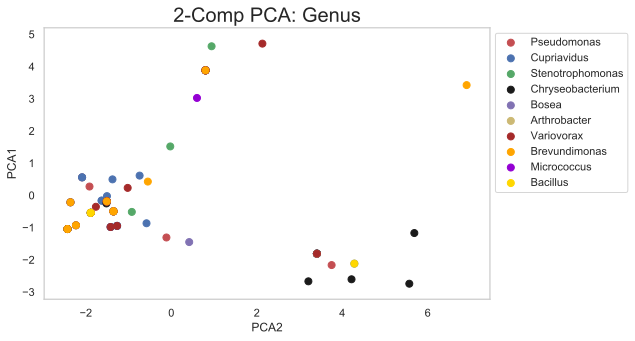

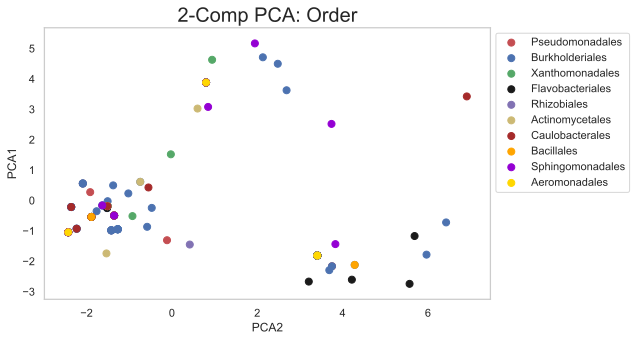

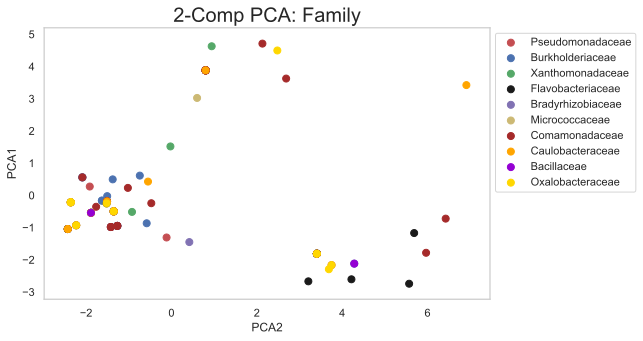

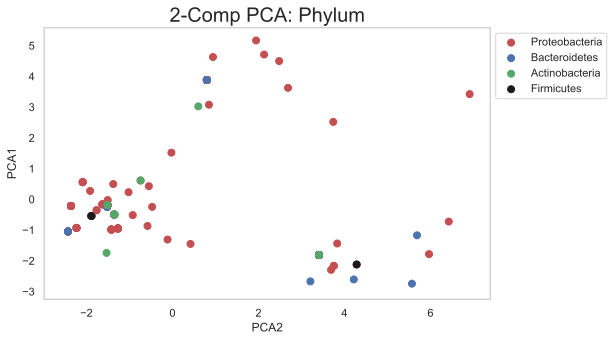

In [24]:
fs = (8,5)

############
## GENUS ###
############

targs = df['Genus'].unique()
fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Genus", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfg['Genus'] == targ
    ax.scatter(mdfg.loc[idxkeep, "pc1"],
               mdfg.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs, bbox_to_anchor=(1,1))
ax.grid()



############
## ORDER ###
############

targs = df['Order'].unique()
fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Order", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfo['Order'] == targ
    ax.scatter(mdfo.loc[idxkeep, "pc1"],
               mdfo.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()


############
###FAMILY###
############

targs = df['Family'].unique()

fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Family", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdff['Family'] == targ
    ax.scatter(mdff.loc[idxkeep, "pc1"],
               mdff.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()



############
###PHYLUM###
############


targs = df['Phylum'].unique()

fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title("2-Comp PCA: Phylum", fontsize=20)
colrs = ['r', 'b', 'g', 'k', 'm', 'y', 'brown', 'orange', 'darkviolet', 'gold']
for targ, colr in zip(targs, colrs):
    idxkeep = mdfp['Phylum'] == targ
    ax.scatter(mdfp.loc[idxkeep, "pc1"],
               mdfp.loc[idxkeep, "pc2"],
               c=colr,
               s=50)

ax.legend(targs,bbox_to_anchor=(1,1))
ax.grid()

In [ ]:
## Perhaps a different type of clustering could be used here, but I don't think using antiSmash 
## for that clustering is the right approach